# [Dacon]항공지연예측

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


sns.set()

#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
# from IPython.core.display import display, HTML
from IPython.display import display, HTML

display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# ----------------- 학습 ----------------------
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# ----------------- 모델 ----------------------
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.linear_model import Ridge,Lasso

from lightgbm import LGBMRegressor,LGBMClassifier

# ----------------- 평가 ----------------------
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,mean_squared_error
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve

from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve

# Data Load

<pre>
Month: 해당 항공편의 출발 월입니다. 1부터 12까지의 값을 가집니다.
Day_of_Month: 해당 항공편의 출발 날짜입니다. 1부터 31까지의 값을 가집니다.
Estimated_Departure_Time: 해당 항공편의 출발 예정 시간입니다. 시간은 24시간 형식으로 기록됩니다. (HH:MM)
Estimated_Arrival_Time: 해당 항공편의 도착 예정 시간입니다. 시간은 24시간 형식으로 기록됩니다. (HH:MM)
Cancelled: 해당 항공편이 취소되었는지 여부를 나타냅니다. Train, Test 데이터 모두 0 값만 존재합니다.
Diverted: 해당 항공편이 경유지를 변경하여 다른 공항으로 이동되었는지 여부를 나타냅니다. Train, Test 데이터 모두 0 값만 존재합니다.
Origin_Airport: 해당 항공편의 출발 공항의 IATA 코드입니다.
Origin_Airport_ID: 해당 항공편의 출발 공항의 고유 ID입니다.
Origin_State: 해당 항공편의 출발 공항이 위치한 주(State) 이름입니다.
Destination_Airport: 해당 항공편의 도착 공항의 IATA 코드입니다.
Destination_Airport_ID: 해당 항공편의 도착 공항의 고유 ID입니다.
Destination_State: 해당 항공편의 도착 공항이 위치한 주(State) 이름입니다.
Distance: 해당 항공편의 비행 거리입니다. 확인해보니 마일(mile) 단위로 기록됩니다.
Airline: 해당 항공편을 운항하는 항공사 이름입니다.
Carrier_Code(IATA): 해당 항공편을 운항하는 항공사의 IATA 코드입니다.  (IATA 공항 코드, 단 다른 항공사가 같은 코드를 보유할 수도 있음)
Carrier_ID(DOT): 해당 항공편을 운항하는 항공사의 식별번호입니다. 
Tail_Number: 해당 항공편을 운항하는 항공기의 고유 등록번호입니다.

In [3]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
submit=pd.read_csv('sample_submission.csv')

In [4]:
print(train['ID'].nunique())
print(test['ID'].nunique())

train=train.drop('ID',axis=1)
test=test.drop('ID',axis=1)

1000000
1000000


In [73]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 20 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   Month                          1000000 non-null  int64  
 1   Day_of_Month                   1000000 non-null  int64  
 2   Estimated_Departure_Time       1000000 non-null  float64
 3   Estimated_Arrival_Time         1000000 non-null  float64
 4   Origin_Airport                 1000000 non-null  object 
 5   Origin_Airport_ID              1000000 non-null  int64  
 6   Destination_Airport            1000000 non-null  object 
 7   Destination_Airport_ID         1000000 non-null  int64  
 8   Distance                       1000000 non-null  float64
 9   Airline                        1000000 non-null  object 
 10  Tail_Number                    1000000 non-null  object 
 11  Delay                          255001 non-null   object 
 12  Distance(km)   

In [5]:
train['Delay'].value_counts()

Not_Delayed    210001
Delayed         45000
Name: Delay, dtype: int64

# EDA

In [6]:
# fig, axes = plt.subplots(4, 5, figsize=(15, 20)  ) 

# col_list = ['Month', 'Day_of_Month', 'Estimated_Departure_Time',
#        'Estimated_Arrival_Time', 'Cancelled', 'Diverted', 'Origin_Airport',
#        'Origin_Airport_ID', 'Origin_State', 'Destination_Airport',
#        'Destination_Airport_ID', 'Destination_State', 'Distance', 'Airline',
#        'Carrier_Code(IATA)', 'Carrier_ID(DOT)', 'Tail_Number']
# for i, col in enumerate(col_list) :  #train.columns) :
#     r = i//5
#     c = i%5
#     #print(i,r, c ,col)
#     axes[r][c].set_title(col)
#     sns.histplot(data=train, x=col, ax=axes[r][c],     kde=True )
#     sns.histplot(data=test, x=col, ax=axes[r][c],     kde=True )
#     # axes[0][0].set_title("count")
#     # sns.histplot(data=train, x='count', ax=axes[0][0],     kde=True )

# plt.tight_layout()
# plt.show()

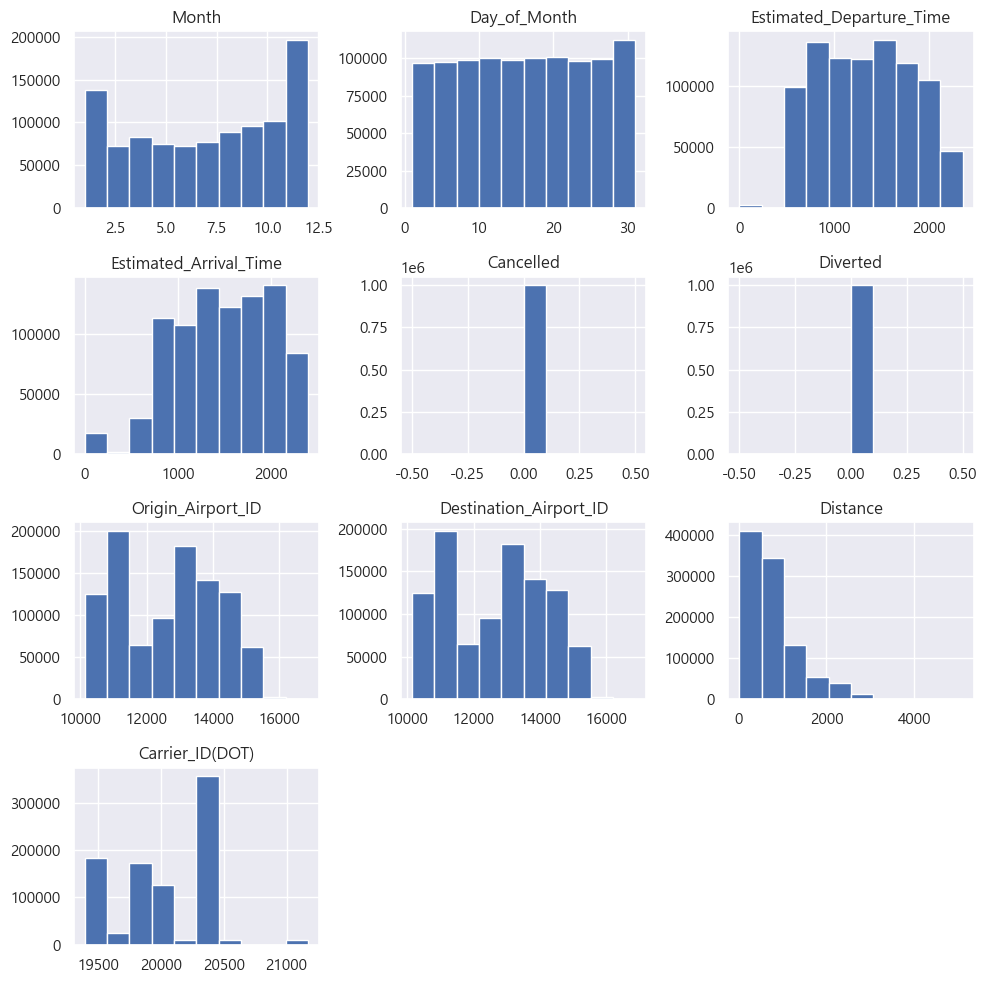

In [7]:
train.hist(figsize=(10,10))

plt.tight_layout()
plt.show()

# 결측

In [8]:
train.isna().sum()[train.isna().sum()>0]

Estimated_Departure_Time    109019
Estimated_Arrival_Time      109040
Origin_State                109015
Destination_State           109079
Airline                     108920
Carrier_Code(IATA)          108990
Carrier_ID(DOT)             108997
Delay                       744999
dtype: int64

In [9]:
test.isna().sum()[test.isna().sum()>0]

Estimated_Departure_Time    108984
Estimated_Arrival_Time      109048
Origin_State                106505
Destination_State           106523
Airline                     106527
Carrier_Code(IATA)          108993
Carrier_ID(DOT)             109006
dtype: int64

## Carrier_Code(IATA)

- Carrier_Code(IATA)          108990    -> 항공사 다른데 IATA코드 동일한 경우가 있음--> 삭제
- Carrier_ID(DOT)             108997

In [10]:
train[['Carrier_Code(IATA)', 'Carrier_ID(DOT)']].head()

,Carrier_Code(IATA),Carrier_ID(DOT)
0,WN,19393.0
1,UA,20304.0
2,AA,19805.0
3,UA,NaN
4,UA,20304.0


In [11]:
train[['Carrier_Code(IATA)','Carrier_ID(DOT)']].value_counts().sort_index()

Carrier_Code(IATA)  Carrier_ID(DOT)
AA                  19805.0             73759
                    20237.0               371
                    20304.0              9017
                    20366.0               737
                    20378.0              9067
                    20397.0             22177
                    20398.0             24544
                    20427.0              8818
                    20452.0             11099
                    21167.0              2775
AS                  19687.0             11644
                    19930.0             25991
                    20225.0               126
                    20304.0              5178
B6                  20409.0             37007
DL                  19790.0             80111
                    20304.0             28002
                    20363.0             20644
                    20366.0               804
                    20452.0              5272
                    20500.0              392

In [12]:
train[['Airline','Carrier_Code(IATA)']].value_counts().sort_index()

Airline                                    Carrier_Code(IATA)
Air Wisconsin Airlines Corp                UA                     11950
Alaska Airlines Inc.                       AS                     26021
Allegiant Air                              G4                     12193
American Airlines Inc.                     AA                     73629
Cape Air                                   UA                       105
Capital Cargo International                AA                      8814
Comair Inc.                                AA                     22071
Commutair Aka Champlain Enterprises, Inc.  UA                      6393
Compass Airlines                           AA                      2819
                                           DL                      5049
Delta Air Lines Inc.                       DL                     79922
Empire Airlines Inc.                       HA                       946
Endeavor Air Inc.                          DL                     20668
En

## Airline

### 'Carrier_ID(DOT)' -- > 'Airline'

In [13]:
print(train['Carrier_ID(DOT)'].isna().sum())
print(test['Carrier_ID(DOT)'].isna().sum())

108997
109006


In [14]:
train[['Airline','Carrier_ID(DOT)']].value_counts().sort_index()

Airline                                    Carrier_ID(DOT)
Air Wisconsin Airlines Corp                20046.0             11894
Alaska Airlines Inc.                       19930.0             25954
Allegiant Air                              20368.0             12182
American Airlines Inc.                     19805.0             73835
Cape Air                                   20253.0               107
Capital Cargo International                20427.0              8884
Comair Inc.                                20397.0             22030
Commutair Aka Champlain Enterprises, Inc.  20445.0              6340
Compass Airlines                           21167.0              7898
Delta Air Lines Inc.                       19790.0             80026
Empire Airlines Inc.                       20263.0               940
Endeavor Air Inc.                          20363.0             20650
Envoy Air                                  20398.0             24455
ExpressJet Airlines Inc.                   2

In [15]:
train['Carrier_ID(DOT)'].isna().sum()

108997

In [16]:
temp = train[['Carrier_ID(DOT)', 'Airline']]
temp = temp.dropna(axis=0)
temp = temp.drop_duplicates()   # Carrier_ID(DOT)' ,'Airline' 두개가 쌍으로 모두 동일한 경우만 삭제
# print(temp)

cntdf = temp.groupby('Carrier_ID(DOT)').count()  #   Carrier_ID(DOT) 1개인데, Airline가 여러개인경우가 있다
cntdf[cntdf['Airline'] == 1]
tail_one = cntdf[cntdf['Airline'] == 1].index
temp = temp.set_index('Carrier_ID(DOT)')
temp = temp.loc[tail_one]
temp = temp.reset_index()
tail_dic = dict(temp.values)
# print(tail_dic)

train['Airline'] = train.apply(lambda x: tail_dic[x['Carrier_ID(DOT)']] if (pd.isnull(x['Airline'])) and (x['Carrier_ID(DOT)'] in tail_dic.keys()) else x['Airline'],  axis=1)
test['Airline'] = test.apply(lambda x: tail_dic[x['Carrier_ID(DOT)']] if (pd.isnull(x['Airline'])) and (x['Carrier_ID(DOT)'] in tail_dic.keys()) else x['Airline'],  axis=1)
train[train['Airline'].isna()].shape[0], test[test['Airline'].isna()].shape[0]

(11883, 11543)

### 'Tail_Number' --> 'Airline'

In [17]:
train['Tail_Number'].nunique()

6430

In [18]:
temp=train[['Tail_Number','Airline']]
temp = temp.dropna(axis=0)
tail_num_dic=dict(temp.values)

train['Airline'] = train.apply(lambda x: tail_num_dic[x['Tail_Number']] if (pd.isnull(x['Airline'])) and (x['Tail_Number'] in tail_num_dic.keys()) else x['Airline'],  axis=1)
test['Airline'] = test.apply(lambda x: tail_num_dic[x['Tail_Number']] if (pd.isnull(x['Airline'])) and (x['Tail_Number'] in tail_num_dic.keys()) else x['Airline'],  axis=1)
train[train['Airline'].isna()].shape[0], test[test['Airline'].isna()].shape[0]

(2, 56)

In [19]:
train[train['Airline'].isna()]

,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
382926,10,31,1740.0,NaN,0,0,HNL,12173,Hawaii,ATL,10397,Georgia,4502.0,NaN,DL,NaN,N867DA,NaN
856500,1,13,2205.0,705.0,0,0,OGG,13830,Hawaii,SLC,14869,NaN,2935.0,NaN,DL,NaN,N153DL,NaN


In [20]:
train['Airline'][train['Carrier_Code(IATA)']=='DL'].value_counts()

Delta Air Lines Inc.                        89853
SkyWest Airlines Inc.                       31355
Endeavor Air Inc.                           23177
Republic Airlines                            5938
Compass Airlines                             5650
GoJet Airlines, LLC d/b/a United Express     4379
ExpressJet Airlines Inc.                      912
Name: Airline, dtype: int64

In [21]:
a=train['Airline'][train['Carrier_Code(IATA)']=='DL'].mode()[0]
b=test['Airline'][test['Carrier_Code(IATA)']=='DL'].mode()[0]

In [22]:
test['Airline'][test['Carrier_Code(IATA)']=='DL'].value_counts()

Delta Air Lines Inc.                        86173
SkyWest Airlines Inc.                       28839
Endeavor Air Inc.                           21625
Republic Airlines                            5932
Compass Airlines                             5263
GoJet Airlines, LLC d/b/a United Express     4002
ExpressJet Airlines Inc.                      847
Name: Airline, dtype: int64

### mode()

In [23]:
train['Airline']=train['Airline'].fillna(a)
test['Airline']=test['Airline'].fillna(b)

### 확인

In [24]:
print(train['Airline'].isna().sum())
print(test['Airline'].isna().sum())

0
0


In [25]:
train['Airline'].value_counts()

Southwest Airlines Co.                       204190
Delta Air Lines Inc.                         100926
SkyWest Airlines Inc.                         97475
United Air Lines Inc.                         94375
American Airlines Inc.                        92893
JetBlue Airways                               46686
Republic Airlines                             37560
Alaska Airlines Inc.                          32656
Envoy Air                                     30860
Spirit Air Lines                              28091
Comair Inc.                                   27875
Mesa Airlines Inc.                            27655
Endeavor Air Inc.                             25958
ExpressJet Airlines Inc.                      22631
Frontier Airlines Inc.                        19599
Allegiant Air                                 15402
Air Wisconsin Airlines Corp                   15005
Horizon Air                                   14689
Hawaiian Airlines Inc.                        12233
Capital Carg

## Carrier_ID(DOT)
- Airline과 동일(drop)

In [26]:
print(train.isna().sum()[train.isna().sum()>0])
print()
print(test.isna().sum()[test.isna().sum()>0])

Estimated_Departure_Time    109019
Estimated_Arrival_Time      109040
Origin_State                109015
Destination_State           109079
Carrier_Code(IATA)          108990
Carrier_ID(DOT)             108997
Delay                       744999
dtype: int64

Estimated_Departure_Time    108984
Estimated_Arrival_Time      109048
Origin_State                106505
Destination_State           106523
Carrier_Code(IATA)          108993
Carrier_ID(DOT)             109006
dtype: int64


In [27]:
train['Carrier_ID(DOT)'].value_counts()

19393.0    182025
19790.0     89958
20304.0     86902
19977.0     83984
19805.0     82860
20409.0     41615
20452.0     33351
19930.0     29085
20398.0     27474
20416.0     24983
20397.0     24838
20378.0     24699
20363.0     23113
20366.0     20197
20436.0     17440
20368.0     13739
20046.0     13319
19687.0     13107
19690.0     10921
20427.0      9962
20500.0      9532
20237.0      9321
21167.0      8813
20445.0      7124
21171.0      1324
20263.0      1052
20225.0       142
20253.0       123
Name: Carrier_ID(DOT), dtype: int64

## Origin_State / Destination_State

In [28]:
train[['Origin_Airport','Origin_Airport_ID','Origin_State']].isna().sum()

Origin_Airport            0
Origin_Airport_ID         0
Origin_State         109015
dtype: int64

In [29]:
train['Origin_Airport'].nunique(), train['Origin_Airport_ID'].nunique()

(374, 374)

In [30]:
train['Origin_State'].unique()

array(['Oklahoma', 'Illinois', 'North Carolina', 'California', nan,
       'New Jersey', 'Arkansas', 'Virginia', 'Pennsylvania', 'Ohio',
       'Texas', 'Arizona', 'Connecticut', 'Maryland', 'New York',
       'Florida', 'Washington', 'Utah', 'New Mexico', 'Colorado',
       'Oregon', 'Georgia', 'Missouri', 'Tennessee', 'Alaska',
       'Minnesota', 'Maine', 'Nebraska', 'Hawaii', 'Nevada', 'Alabama',
       'Montana', 'North Dakota', 'Michigan', 'Wyoming', 'South Carolina',
       'Indiana', 'Louisiana', 'Massachusetts', 'Kentucky', 'Wisconsin',
       'Puerto Rico', 'West Virginia', 'Mississippi', 'Iowa', 'Vermont',
       'Idaho', 'New Hampshire', 'U.S. Virgin Islands', 'Kansas',
       'South Dakota', 'Rhode Island',
       'U.S. Pacific Trust Territories and Possessions'], dtype=object)

### Origin_Airport_ID --> Origin_State

In [31]:
train[['Origin_State','Origin_Airport_ID']].value_counts().sort_index()

Origin_State  Origin_Airport_ID
Alabama       10562                   5
              10599                2153
              11308                 136
              12217                1074
              13277                 415
                                   ... 
Wyoming       11233                  28
              11865                  95
              12441                 565
              12888                  79
              14543                  98
Length: 374, dtype: int64

In [32]:
train[train['Origin_State'].isna()].head(3)

,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
5,4,13,1545.0,NaN,0,0,EWR,11618,NaN,DCA,11278,Virginia,199.0,Republic Airlines,UA,20452.0,N657RW,Not_Delayed
8,6,13,1420.0,1550.0,0,0,BWI,10821,NaN,CLT,11057,North Carolina,361.0,Southwest Airlines Co.,WN,19393.0,N765SW,Not_Delayed
18,8,11,1215.0,1258.0,0,0,CRW,11146,NaN,ORD,13930,NaN,416.0,Air Wisconsin Airlines Corp,NaN,20046.0,N440AW,NaN


In [33]:
train['Origin_State'][train['Origin_Airport_ID']==10821]

8              NaN
20        Maryland
69        Maryland
131       Maryland
133       Maryland
            ...   
999698         NaN
999765    Maryland
999794    Maryland
999827    Maryland
999855    Maryland
Name: Origin_State, Length: 15218, dtype: object

In [34]:
temp=train[['Origin_Airport_ID','Origin_State']]
temp = temp.dropna(axis=0)
temp = temp.drop_duplicates()
origin_dic=dict(temp.values)

train['Origin_State'] = train.apply(lambda x: origin_dic[x['Origin_Airport_ID']] if (pd.isnull(x['Origin_State'])) and (x['Origin_Airport_ID'] in origin_dic.keys()) else x['Origin_State'],  axis=1)
test['Origin_State'] = test.apply(lambda x: origin_dic[x['Origin_Airport_ID']] if (pd.isnull(x['Origin_State'])) and (x['Origin_Airport_ID'] in origin_dic.keys()) else x['Origin_State'],  axis=1)
train[train['Origin_State'].isna()].shape[0], test[test['Origin_State'].isna()].shape[0]

(0, 28)

### [test]Origin_State
- Origin_State / Destination_State --> drop

In [35]:
test['Destination_State'][test['Destination_Airport']=='RIW']

59620     NaN
272704    NaN
290941    NaN
348833    NaN
418390    NaN
475102    NaN
583499    NaN
865492    NaN
866469    NaN
935232    NaN
986455    NaN
Name: Destination_State, dtype: object

In [36]:
test['Origin_Airport_ID'][test['Origin_State'].isna()].values

array([14534, 14812, 11283, 14534, 14812, 14534, 14534, 11283, 14812,
       14812, 14812, 14534, 14534, 11288, 14812, 11283, 11283, 11288,
       14534, 14534, 14812, 14534, 14534, 11283, 14812, 14812, 14812,
       14812], dtype=int64)

In [37]:
test['Origin_Airport'][test['Origin_State'].isna()].values

array(['RIW', 'SHR', 'DDC', 'RIW', 'SHR', 'RIW', 'RIW', 'DDC', 'SHR',
       'SHR', 'SHR', 'RIW', 'RIW', 'DEC', 'SHR', 'DDC', 'DDC', 'DEC',
       'RIW', 'RIW', 'SHR', 'RIW', 'RIW', 'DDC', 'SHR', 'SHR', 'SHR',
       'SHR'], dtype=object)

In [38]:
test[['Origin_Airport','Origin_Airport_ID','Origin_State','Destination_State']][(test['Distance']==139.0)].head()

,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_State
421,MLI,13367,Illinois,Illinois
1737,MLI,13367,Illinois,Illinois
2050,MLI,13367,Illinois,Illinois
4007,ORD,13930,Illinois,Illinois
5508,MLI,13367,Illinois,Illinois


In [39]:
test[['Origin_Airport','Origin_State']].value_counts().sort_index()

Origin_Airport  Origin_State
ABE             Pennsylvania     739
ABI             Texas            230
ABQ             New Mexico      3517
ABR             South Dakota      69
ABY             Georgia           90
                                ... 
XWA             North Dakota      25
YAK             Alaska            78
YKM             Washington       154
YNG             Ohio               1
YUM             Arizona          151
Length: 375, dtype: int64

In [40]:
temp=test[['Origin_Airport','Origin_Airport_ID','Origin_State','Distance']]
temp = temp.drop_duplicates()
temp.head(3)

,Origin_Airport,Origin_Airport_ID,Origin_State,Distance
0,IAH,12266,Texas,191.0
1,EWR,11618,New Jersey,746.0
2,ORD,13930,Illinois,733.0


## Estimated_Departure_Time / Estimated_Arrival_Time 

### 파생변수 Distance(km)
- Distance는 마일 단위 --> Distance*1.60934= km단위로 변경

In [41]:
train['Distance(km)']=train['Distance']*1.60934
test['Distance(km)']=test['Distance']*1.60934
test[['Distance','Distance(km)']].head(3)

,Distance,Distance(km)
0,191.0,307.38394
1,746.0,1200.56764
2,733.0,1179.64622


In [42]:
train[['Estimated_Departure_Time','Estimated_Arrival_Time','Distance(km)']][(train['Estimated_Departure_Time'].isna())].head()

,Estimated_Departure_Time,Estimated_Arrival_Time,Distance(km)
0,NaN,NaN,674.31346
25,NaN,2020.0,994.57212
74,NaN,749.0,949.51060
100,NaN,1446.0,1488.63950
102,NaN,2139.0,669.48544


In [43]:
train[['Estimated_Departure_Time','Estimated_Arrival_Time','Distance']][(train['Estimated_Departure_Time'].isna())&(train['Estimated_Arrival_Time'].isna())].shape

(11688, 3)

### 석영님

In [44]:
train.isna().sum()[train.isna().sum()>0]

Estimated_Departure_Time    109019
Estimated_Arrival_Time      109040
Destination_State           109079
Carrier_Code(IATA)          108990
Carrier_ID(DOT)             108997
Delay                       744999
dtype: int64

In [45]:
test.isna().sum()[test.isna().sum()>0]

Estimated_Departure_Time    108984
Estimated_Arrival_Time      109048
Origin_State                    28
Destination_State           106523
Carrier_Code(IATA)          108993
Carrier_ID(DOT)             109006
dtype: int64

In [46]:
time_df=pd.read_csv("sy_time.csv")
time_df
time_df[['estimated_departure_time','estimated_arrival_time']].isna().sum()

# train['Estimated_Departure_Time']=time_df['estimated_departure_time']
# train['Estimated_Arrival_Time']=time_df['estimated_arrival_time']

estimated_departure_time    0
estimated_arrival_time      0
dtype: int64

#### 결측처리

- Distance(km)=(Estimated_Departure_Time - Estimated_Arrival_Time) * 900
- Estimated_Departure_Time= ( Distance(km) / 900)+Estimated_Arrival_Time 

In [47]:
train['Estimated_Arrival_Time'].isna().sum(),train['Estimated_Departure_Time'].isna().sum()

(109040, 109019)

In [48]:
dt_idx=train[train['Estimated_Departure_Time'].isna()].index.values
dt_te_idx=test[test['Estimated_Departure_Time'].isna()].index.values

at_idx=train[train['Estimated_Arrival_Time'].isna()].index.values
at_te_idx=test[test['Estimated_Arrival_Time'].isna()].index.values

In [49]:
train['Estimated_Departure_Time'].loc[dt_idx]=(train['Distance(km)']/900)+train['Estimated_Arrival_Time']
test['Estimated_Departure_Time'].loc[dt_te_idx]=(test['Distance(km)']/900)+test['Estimated_Arrival_Time']
train['Estimated_Departure_Time'].isna().sum(),test['Estimated_Departure_Time'].isna().sum()

(11688, 11928)

- Distance(km)=(Estimated_Departure_Time - Estimated_Arrival_Time) * 900
- Estimated_Arrival_Time = (900/Distance(km))+Estimated_Departure_Time

In [50]:
train['Estimated_Arrival_Time'].loc[at_idx]=(900/train['Distance(km)'])+train['Estimated_Departure_Time']
test['Estimated_Arrival_Time'].loc[at_te_idx]=(900/test['Distance(km)'])+test['Estimated_Departure_Time']
train['Estimated_Arrival_Time'].isna().sum(),test['Estimated_Arrival_Time'].isna().sum()

(11688, 11928)

- 둘다 결측인것 처리

In [51]:
idx=train[(train['Estimated_Arrival_Time'].isna())&(train['Estimated_Departure_Time'].isna())].index.values
idx2=test[(test['Estimated_Arrival_Time'].isna())&(test['Estimated_Departure_Time'].isna())].index.values

In [52]:
train['Estimated_Arrival_Time'].loc[idx]=time_df['estimated_arrival_time'].loc[idx]
test['Estimated_Arrival_Time'].loc[idx2]=time_df['estimated_arrival_time'].loc[idx2]

train['Estimated_Departure_Time'].loc[idx]=time_df['estimated_departure_time'].loc[idx]
test['Estimated_Departure_Time'].loc[idx2]=time_df['estimated_departure_time'].loc[idx2]

In [53]:
train['Estimated_Arrival_Time'].isna().sum(),test['Estimated_Arrival_Time'].isna().sum()

(0, 0)

In [54]:
train['Estimated_Departure_Time'].isna().sum(),test['Estimated_Departure_Time'].isna().sum()

(0, 0)

### 거리= 속력* 시간

In [55]:
train[['Estimated_Departure_Time','Estimated_Arrival_Time','Distance']][(train['Estimated_Departure_Time'].notna())&(train['Estimated_Arrival_Time'].notna())].head()

,Estimated_Departure_Time,Estimated_Arrival_Time,Distance
0,1418.895,1560.15,419.0
1,740.000,1024.00,1250.0
2,1610.000,1805.00,544.0
3,905.000,1735.00,2454.0
4,900.000,1019.00,250.0


#### 파생변수 Estimated_Departure_Time_hour/min   &   Estimated_Arrival_Time_hour/min


In [56]:
train['Estimated_Arrival_Time']=np.where(train['Estimated_Departure_Time']>train['Estimated_Arrival_Time'],train['Estimated_Arrival_Time']+2400,train['Estimated_Arrival_Time'])
test['Estimated_Arrival_Time']=np.where(test['Estimated_Departure_Time']>test['Estimated_Arrival_Time'],test['Estimated_Arrival_Time']+2400,test['Estimated_Arrival_Time'])

In [57]:
train['Estimated_Departure_Time_hour']=train['Estimated_Departure_Time']//100
train['Estimated_Departure_Time_min']=train['Estimated_Departure_Time']%100

train['Estimated_Arrival_Time_hour']=train['Estimated_Arrival_Time']//100
train['Estimated_Arrival_Time_min']=train['Estimated_Arrival_Time']%100


test['Estimated_Departure_Time_hour']=test['Estimated_Departure_Time']//100
test['Estimated_Departure_Time_min']=test['Estimated_Departure_Time']%100

test['Estimated_Arrival_Time_hour']=test['Estimated_Arrival_Time']//100
test['Estimated_Arrival_Time_min']=test['Estimated_Arrival_Time']%100

In [58]:
train[['Estimated_Departure_Time_hour','Estimated_Departure_Time_min','Estimated_Arrival_Time_hour','Estimated_Arrival_Time_min']].head()

,Estimated_Departure_Time_hour,Estimated_Departure_Time_min,Estimated_Arrival_Time_hour,Estimated_Arrival_Time_min
0,14.0,18.895,15.0,60.15
1,7.0,40.000,10.0,24.00
2,16.0,10.000,18.0,5.00
3,9.0,5.000,17.0,35.00
4,9.0,0.000,10.0,19.00


#### 파생변수 Duration_of_Time_hour + min = Duration_of_Time 


In [59]:
train['Duration_of_Time_hour']=train['Estimated_Arrival_Time_hour']-train['Estimated_Departure_Time_hour']
train['Duration_of_Time_min']=train['Estimated_Arrival_Time_min']-train['Estimated_Departure_Time_min']

test['Duration_of_Time_hour']=test['Estimated_Arrival_Time_hour']-test['Estimated_Departure_Time_hour']
test['Duration_of_Time_min']=test['Estimated_Arrival_Time_min']-test['Estimated_Departure_Time_min']

In [60]:
train['Duration_of_Time_min']=np.where(train['Duration_of_Time_min']<0,train['Duration_of_Time_min']+60,train['Duration_of_Time_min'])
test['Duration_of_Time_min']=np.where(test['Duration_of_Time_min']<0,test['Duration_of_Time_min']+60,test['Duration_of_Time_min'])

In [61]:
test['Duration_of_Time_min'][test['Duration_of_Time_min']<0]

778      -14.805000
3023      -3.142500
11339     -5.477167
16629     -0.250507
18442    -26.997146
            ...    
963606   -19.102167
976102   -33.130000
978294    -3.481667
995068   -18.328500
997788   -23.553333
Name: Duration_of_Time_min, Length: 180, dtype: float64

In [62]:
train['Duration_of_Time_min']=train['Duration_of_Time_min']/60
test['Duration_of_Time_min']=test['Duration_of_Time_min']/60

In [63]:
train['Duration_of_Time']=train['Duration_of_Time_min']+train['Duration_of_Time_hour']
test['Duration_of_Time']=test['Duration_of_Time_min']+test['Duration_of_Time_hour']

In [64]:
print(train.isna().sum()[train.isna().sum()>0])
print()
print(test.isna().sum()[test.isna().sum()>0])

Destination_State     109079
Carrier_Code(IATA)    108990
Carrier_ID(DOT)       108997
Delay                 744999
dtype: int64

Origin_State              28
Destination_State     106523
Carrier_Code(IATA)    108993
Carrier_ID(DOT)       109006
dtype: int64


### Estimated_Departure_Time, Estimated_Arrival_Time /100

In [65]:
train['Estimated_Departure_Time']=train['Estimated_Departure_Time']/100
test['Estimated_Departure_Time']=test['Estimated_Departure_Time']/100

train['Estimated_Arrival_Time']=train['Estimated_Arrival_Time']/100
test['Estimated_Arrival_Time']=test['Estimated_Arrival_Time']/100

# 삭제

## Diverted  --> drop

- 경유지 변경된 비행기 없음 

In [66]:
train=train.drop('Diverted',axis=1)
test=test.drop('Diverted',axis=1)

## Cancelled  --> drop
- 0 값 밖에 없음

In [67]:
train=train.drop('Cancelled',axis=1)
test=test.drop('Cancelled',axis=1)

## Carrier_Code(IATA)  --> drop
- Airline과 1:1매칭이기 때문에 필요 없음

In [68]:
train=train.drop('Carrier_Code(IATA)',axis=1)
test=test.drop('Carrier_Code(IATA)',axis=1)

## Carrier_ID(DOT)  --> drop
- Airline과 1:1매칭이기 때문에 필요 없음

In [69]:
train=train.drop('Carrier_ID(DOT)',axis=1)
test=test.drop('Carrier_ID(DOT)',axis=1)

## Origin_State / Destination_State   -->  drop
- Origin_State / Destination_State에 동일한 결측
- Origin_Airport , Origin_Airport_ID, Origin_State --> 1:1:1   => 결측있는 Origin_State 삭제
- Destination_Airport , Destination_Airport_ID, Destination_State --> 1:1:1   => 결측있는 Origin_State 삭제

In [70]:
train=train.drop('Origin_State',axis=1)
test=test.drop('Origin_State',axis=1)

train=train.drop('Destination_State',axis=1)
test=test.drop('Destination_State',axis=1)

In [71]:
train.to_csv('./train_2.csv')
test.to_csv('./test_2.csv')

In [72]:
ㅁㄴㅇㄻㄴㅇㄻㄴㅇㄻㄴㅇㄹ

NameError: name 'ᄆᄂᄋᆱᄂᄋᆱᄂᄋᆱᄂᄋᄅ' is not defined

## 불필요 파생변수 삭제

In [ ]:
# train=train.drop('Duration_of_Time_hour',axis=1)
# test=test.drop('Duration_of_Time_hour',axis=1)

# train=train.drop('Duration_of_Time_min',axis=1)
# test=test.drop('Duration_of_Time_min',axis=1)

# train=train.drop('Distance(km)',axis=1)
# test=test.drop('Distance(km)',axis=1)

# train=train.drop('Estimated_Departure_Time_min',axis=1)
# test=test.drop('Estimated_Departure_Time_min',axis=1)

# train=train.drop('Estimated_Departure_Time_hour',axis=1)
# test=test.drop('Estimated_Departure_Time_hour',axis=1)

# train=train.drop('Estimated_Arrival_Time_min',axis=1)
# test=test.drop('Estimated_Arrival_Time_min',axis=1)

# train=train.drop('Estimated_Arrival_Time_hour',axis=1)
# test=test.drop('Estimated_Arrival_Time_hour',axis=1)

## 확인 

In [ ]:
print(train.columns)
print(test.columns)

In [ ]:
train.shape

In [ ]:
train[(train['Delay'].notna())&(train['Delay']=='Not_Delayed')].shape

In [ ]:
# train.to_csv('./train_1.csv')
# test.to_csv('./test_1.csv')

# 변수


In [ ]:
train.columns

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(train.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

# 인코딩

In [ ]:
train.info()

In [ ]:
test.info()

# Target training

In [ ]:
train['Delay'][train['Delay'].notna()]

In [ ]:
train['Delay']=train['Delay'].replace(['Not_Delayed','Delayed'],[0,1])

In [ ]:
train['Delay'].value_counts()

In [ ]:

target  = train['Delay']
df = train.drop(['Delay'], axis=1)

df1   = train[ train['Delay'].notna() ]
y_df1 = df1['Delay']
X_df1 = df1.drop('Delay', axis=1)

rf = LGBMRegressor(random_state=11)  #RandomForestRegressor(random_state=11)
X_df1_8, X_df1_2, y_df1_8, y_df1_2 = train_test_split(X_df1, y_df1, test_size=0.2, random_state=11)
rf.fit(X_df1_8, y_df1_8)

pred = rf.predict(X_df1_2)
mse_score = mean_squared_error(y_df1_2, pred)
print("RMSE : ", np.sqrt(mse_score) )

# df0 = df[df['windspeed'] == 0]
# y_df0 = df0['windspeed']
# X_df0 = df0.drop('windspeed', axis=1)
# pred = rf.predict(X_df0)
# widx = X_df0.index.values
# df.loc[widx, 'windspeed'] = pred


In [ ]:
# def my_fill_windspeed(df):
#     target  = df[['regcount','casual','registered', 'regdate']]
#     df = df.drop(['regcount','casual','registered','regdate'], axis=1)
    
#     df1   = df[df['windspeed'] != 0]
#     y_df1 = df1['windspeed']
#     X_df1 = df1.drop('windspeed', axis=1)
    
#     rf = LGBMRegressor(random_state=0)  #RandomForestRegressor(random_state=11)
#     X_df1_8, X_df1_2, y_df1_8, y_df1_2 = train_test_split(X_df1, y_df1, test_size=0.2, random_state=11)
#     rf.fit(X_df1_8, y_df1_8)
    
#     pred = rf.predict(X_df1_2)
#     mse_score = mean_squared_error(y_df1_2, pred)
#     print("RMSE : ", np.sqrt(mse_score) )

#     df0 = df[df['windspeed'] == 0]
#     y_df0 = df0['windspeed']
#     X_df0 = df0.drop('windspeed', axis=1)
#     pred = rf.predict(X_df0)
#     widx = X_df0.index.values
#     df.loc[widx, 'windspeed'] = pred
    
#     return pd.concat([df, target], axis=1)

In [ ]:
코드구경잘하고가요 ~♥ -함-

# 파생변수

## 총 소요시간

In [ ]:
train[['Estimated_Departure_Time','Estimated_Arrival_Time','Origin_Airport','Destination_Airport']][(train['Estimated_Departure_Time'].notna())&(train['Estimated_Arrival_Time'].notna())].head()

- 출발시간보다 도착시간 수가 더 작은 경우는 하루가 넘어갔다는 뜻
- 100으로 나눈 뒤 도착시간에 24더하기 
- Estimated_Arrival_Time - Estimated_Departure_Tim = 총 소요 시간

In [ ]:
train[train['Estimated_Departure_Time']>train['Estimated_Arrival_Time']].head(2)

- 11.0 과 같은 형식은 00시 11분이라는 뜻

In [ ]:
train[(train['Origin_Airport']=='LAS')&(train['Destination_Airport']=='DFW')].head()

- /100 , +24

In [ ]:
train['Estimated_Departure_Time']=train['Estimated_Departure_Time']/100
train['Estimated_Arrival_Time']=train['Estimated_Arrival_Time']/100

In [ ]:
train['Estimated_Arrival_Time']=np.where(train['Estimated_Departure_Time']>train['Estimated_Arrival_Time'],train['Estimated_Arrival_Time']+24,train['Estimated_Arrival_Time'])

In [ ]:
train['Duration_of_Time']=train['Estimated_Arrival_Time']-train['Estimated_Departure_Time']
train[['Estimated_Arrival_Time','Estimated_Departure_Time','Duration_of_Time']].head(6)

In [ ]:
train[train['Estimated_Departure_Time']>train['Estimated_Arrival_Time']].head(2)

In [ ]:
# train['Estimated_Departure_Time_1']=np.where(train['Estimated_Departure_Time']==0,train['Estimated_Departure_Time']==(train['Distance(km)']/900)+train['Estimated_Arrival_Time'],  train['Estimated_Departure_Time'])
# test['Estimated_Departure_Time']=np.where(test['Estimated_Departure_Time'].isna(),test['Estimated_Departure_Time']=(test['Distance(km)']/900)+test['Estimated_Arrival_Time'],test['Estimated_Departure_Time'])

# train['Estimated_Departure_Time'].isna().sum(),test['Estimated_Departure_Time'].isna().sum()
# trian['Estimated_Departure_Time']=(train['Distance(km)']/900)+train['Estimated_Arrival_Time']

In [ ]:
# train['Estimated_Departure_Time_1'][train['Estimated_Departure_Time_1']==0]

In [ ]:
# train['Estimated_Arrival_Time']=np.where(train['Estimated_Arrival_Time'].isna(),train['Estimated_Arrival_Time']=(900/train['Distance(km)'])+train['Estimated_Departure_Time'],train['Estimated_Arrival_Time'])
# test['Estimated_Arrival_Time']=np.where(test['Estimated_Arrival_Time'].isna(),test['Estimated_Arrival_Time']=(900/test['Distance(km)'])+test['Estimated_Departure_Time'],test['Estimated_Arrival_Time'])

# train['Estimated_Arrival_Time'].isna().sum(),test['Estimated_Arrival_Time'].isna().sum()

In [ ]:
# train[['Estimated_Departure_Time','Estimated_Arrival_Time']][train['Estimated_Departure_Time']==0]

# target

In [ ]:
train[['Airline','Delay']].value_counts().sort_index()